In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 1
%aimport lab4
%matplotlib inline

In [4]:
from lab2 import *

def f7(x):
    x2 = np.sum(np.square(x))
    return x2**0.25 + (1 + np.sin(50 * x2**0.1)**2)

f7([0,0])

1.0

In [6]:
def default_params(deg=5):
    return {
    'n': 50,
    'chromosome': {
        'class': lab4.RealChromosone,
        'params': {
            'lower': -50,
            'upper': 150,
            'degree': deg,
            'crossover_fn': 'uniform',
            'b': 5
        }
    },
    'selection': 'generation',
    'probs': {
        'type': 'simple',
        'a': 1e-4
    }
}

def default_binary(deg=3):
    return {
        'n': 50,
        'chromosome': {
            'class': lab4.BinaryChromosone,
            'params': {
                'lower': -50,
                'upper': 150,
                'degree': deg,
                'precision': 4,  # Broj decimala
                'crossover_fn': 'uniform',
                'pc': 0.5,
                'pm': 0.3
            }
    },
    'selection': 'generation',
    'probs': {
        'type': 'simple',
        'a': 1e-4
    }
}

# 1

Isprobajte vašu implementaciju GA nad svim funkcijama uz granice [-50, 150] za sve varijable. Za
funkciju f3 odaberite barem 5 varijabli, a za f6 i f7 dvije varijable. Za sve funkcije možete smatrati
da je rješenje pronađeno ako je krajnja vrijednost funkcije cilja manja od 10 -6 . Za neke funkcije
algoritam će biti potrebno pokrenuti nekoliko puta. Koje zaključke možete donijeti o uspješnosti GA
za pojedinu funkciju? Koje su se funkcije pokazale teškim i zašto?

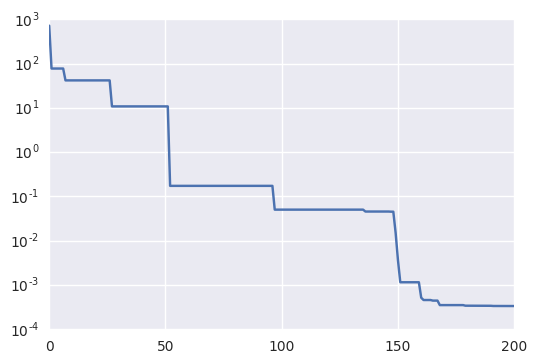

In [4]:
g = lab4.GA(default_params(2))
vals = g.optimize(f1, trace=False)
plt.semilogy(vals)

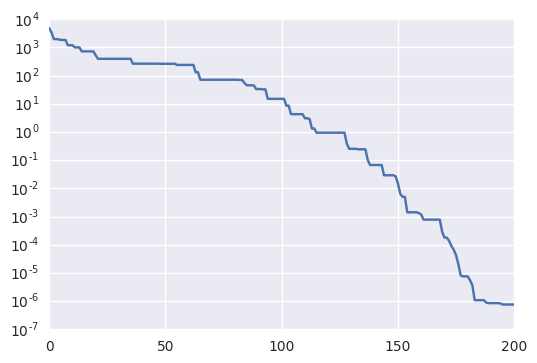

In [5]:
g = lab4.GA(default_params(5))
vals = g.optimize(f3, trace=False)
plt.semilogy(vals)

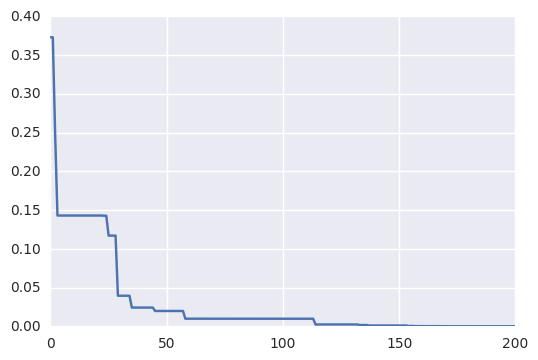

In [6]:
g = lab4.GA(default_params(2))
vals = g.optimize(f6, trace=False)
plt.plot(vals)

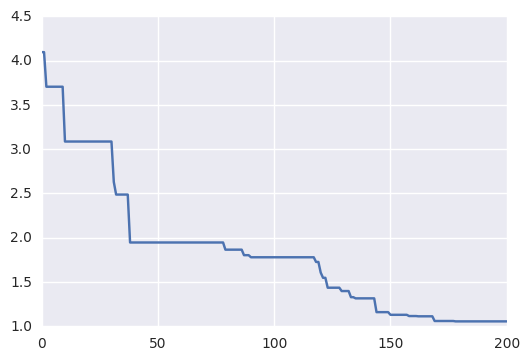

In [7]:
g = lab4.GA(default_params(2))
vals = g.optimize(f7, trace=False)
plt.plot(vals)

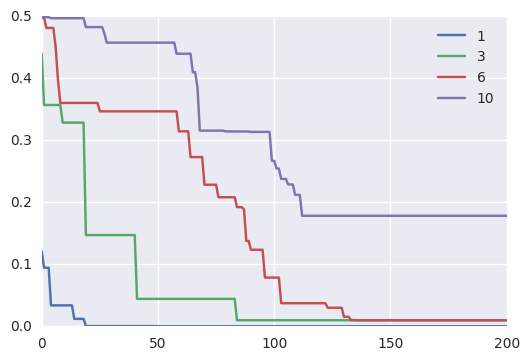

In [7]:
for dim in [1,3,6,10]:
    g = lab4.GA(default_params(dim))
    vals = g.optimize(f6, trace=False)
    plt.plot(vals, label=str(dim))
plt.legend()

# 2

Provedite GA na funkcijama f6 i f7 mijenjajući dimenzionalnost funkcije (1, 3, 6, 10). Kako
povećanje dimenzionalnosti funkcije utječe na ponašanje algoritma?

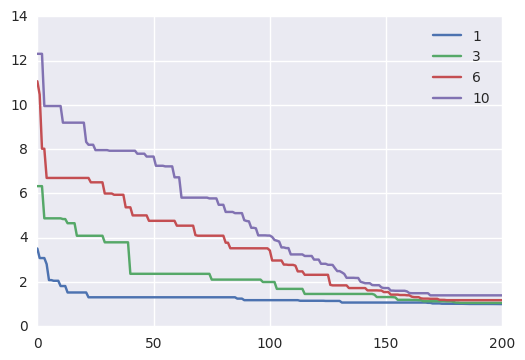

In [8]:
for dim in [1,3,6,10]:
    g = lab4.GA(default_params(dim))
    vals = g.optimize(f7, trace=False)
    plt.plot(vals, label=str(dim))
plt.legend()

# 3

Za funkcije f6 i f7 usporedite učinkovitost GA koji koristi binarni prikaz uz preciznost na 4 decimale
(tj. 10 -4 ) i GA koji koristi prikaz s pomičnom točkom (ostali parametri neka budu jednaki), za
dimenzije 3 i 6. Rad algoritma ograničite zadanim brojem evaluacija (oko 10 5 - 10 6 ). Inačice
algoritma usporedite po uputama u sljedećem odjeljku. Što možete zaključiti o različitim prikazima
rješenja za različite funkcije?

In [11]:
10e4/50  #broj epoha

20000.0

[]

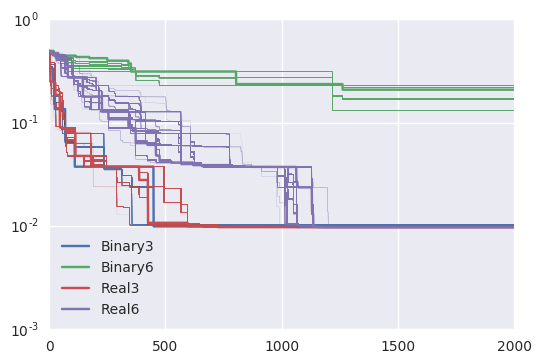

In [9]:
import multiprocessing

def fn_opt6(args):
    g = lab4.GA(args)
    return g.optimize(f6, steps=2000, trace=False)

with multiprocessing.Pool(8) as pool:
    sol3ba = pool.map_async(fn_opt6, [default_binary(3) for _ in range(10)])
    sol6ba = pool.map_async(fn_opt6, [default_binary(6) for _ in range(10)])
    sol3ra = pool.map_async(fn_opt6, [default_params(3) for _ in range(10)])
    sol6ra = pool.map_async(fn_opt6, [default_params(6) for _ in range(10)])
    
    sol6 = np.array([sol3ba.get(), sol6ba.get(), sol3ra.get(), sol6ra.get()]).transpose([1,2,0])

ax = sns.tsplot(sol6, estimator=np.median, condition=["Binary3", "Binary6", "Real3", "Real6"], err_style='boot_traces')
ax.semilogy()

[]

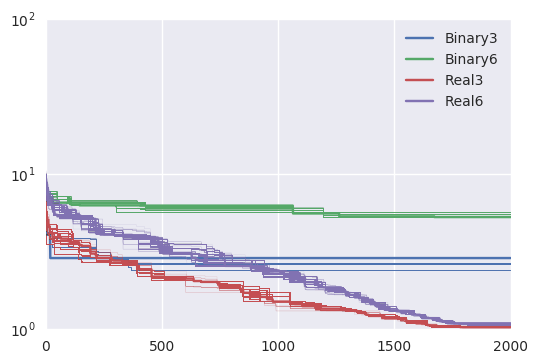

In [8]:
import multiprocessing

def fn_opt7(args):
    g = lab4.GA(args)
    return g.optimize(f7, steps=2000, trace=False)

with multiprocessing.Pool(8) as pool:
    sol3ba = pool.map_async(fn_opt7, [default_binary(3) for _ in range(10)])
    sol6ba = pool.map_async(fn_opt7, [default_binary(6) for _ in range(10)])
    sol3ra = pool.map_async(fn_opt7, [default_params(3) for _ in range(10)])
    sol6ra = pool.map_async(fn_opt7, [default_params(6) for _ in range(10)])
    sol7 = np.array([sol3ba.get(), sol6ba.get(), sol3ra.get(), sol6ra.get()]).transpose([1,2,0])
    
ax = sns.tsplot(sol7, estimator=np.median, condition=["Binary3", "Binary6", "Real3", "Real6"], err_style='boot_traces')
ax.semilogy()

# 4

Za funkciju f6 pokušajte pronaći 'idealne' parametre genetskog algoritma. 'Idealne' parametre
potrebno je odrediti barem za veličinu populacije (npr. 30, 50, 100, 200) i vjerojatnost mutacije
jedinke (npr. 0.1, 0.3, 0.6, 0.9) a po želji možete i za još neke druge parametre koje je vaš algoritam
koristio. Jedan postupak traženja parametara opisan je u nastavku. Koristite medijan kao mjeru
usporedbe i prikažite kretanje učinkovitosti za barem jedan parametar uz pomoć box-plot prikaza
(opisano u nastavku).

In [61]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from hyperopt.mongoexp import MongoTrials


params = {
    'n': hp.choice("n", [30, 50, 100, 200]),
    'chromosome': hp.choice("chromosone", [
        {
            'class': lab4.BinaryChromosone,
            'params': {
                    'lower': -50,
                    'upper': 150,
                    'degree': 5,
                    'precision': 4,  # Broj decimala
                    'crossover_fn': 'uniform',
                    'pc': 0.5,
                    'pm': hp.uniform('pm', 0.1, 0.9)
                }
        },{
            'class': lab4.RealChromosone,
            'params': {
                'lower': -50,
                'upper': 150,
                'degree': 5,
                'crossover_fn': 'uniform',
                'b': hp.uniform('b', 1, 5)
                }
        }
    ]),
    'selection': hp.choice('selection', ['generation', 'tournament']),
    'probs': hp.choice("probs", [{
        'type': 'simple',
        'a': hp.loguniform('a_simple', -3, 1)
        },{
                'type': 'softmax',
                'a':hp.loguniform('a_softmax', -1, 1)
        }])
}

def objective(params):
    g = lab4.GA(args)
#     g.optimize(f6, steps=int(1e4 / g.n), trace=False)
    g.optimize(f6, steps=2, trace=False)


    idx = np.argmin(g.vals)
    x = g.population[idx].eval()
    loss = np.min(g.vals)
    
    return {'loss': loss, 'status': STATUS_OK, 'x':x}

trials = MongoTrials('mongo://localhost:1234/apr/jobs', exp_key='test')
best = fmin(objective, params, trials=trials, algo=tpe.suggest, max_evals=40)

KeyboardInterrupt: 

In [ ]:
sol = []
with multiprocessing.Pool(8) as pool:
    for pop in [30, 50, 100, 200]:
        for pm in [0.1, 0.3, 0.6, 0.9]:
            params = default_params(3)
            params['chromosome']['params']['pm'] = pm
            params['chromosome']['n'] = pop
            pool.map_async(fn_opt6, [params for _ in range(8)])
            for val in pool.get():
                sol.append(pop, pm, val[-1])

# 5

Ako ste implementirali turnirsku selekciju, probajte nad nekom težom funkcijom (f6 ili f7) izvesti
algoritam koristeći različite veličine turnira. Pomaže li veći turnir algoritmu da pronađe bolja
rješenja? Ako ste implementirali roulette wheel selekciju, isprobajte više vrijednosti omjera odabira
najbolje i najlošije jedinke (skaliranje funkcije cilja) te komentirajte dobivene rezultate (također
možete isprobati generacijsku i eliminacijsku varijantu).